# Total momemtum strategy 2013

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import math

## Ranking decile portfolios fucntion

In [1]:
def rank_port_decile_t(equity_data , start_date, end_date):
    
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    equity_data = equity_data[(equity_data.date >= start) & (equity_data.date <= end)]
    equity_data = equity_data.drop_duplicates()
    try:
        equity_data = equity_data[equity_data.RETX != 'C']
    except:
        print('There is no C')
    equity_data.RETX = equity_data.RETX.astype('float64')
    equity_data.RET = equity_data.RET.astype('float64')
    
    equity_group_mean_ret = equity_data.groupby('TICKER').agg({'RETX': 'mean'})
    equity_group_mean_ret_sort = equity_group_mean_ret.sort_values(by=['RETX'])
    equity_group_mean_ret_sort['GROUP'] = 0
    
    frac = math.floor(equity_group_mean_ret_sort.shape[0]/10)
    num_line = equity_group_mean_ret_sort.shape[0]
    left = num_line%frac
    
    group_num = [frac+1]*(left)+[frac]*(10-left)
    
    group = ['P10', 'P09', 'P08', 'P07', 'P06', 'P05', 'P04', 'P03', 'P02', 'P01']
    
    i, j = 0, group_num[0]
    while j <= num_line:
        
        equity_group_mean_ret_sort.ix[(j-group_num[i]):j , 'GROUP'] = group[i]
        i +=1
        if(i == 10):
            break
        j = j + group_num[i]

    return(equity_group_mean_ret_sort)


## Import equity data step

In [4]:
datetime.strptime('2012-06-01', '%Y-%m-%d')

equity_data = pd.read_csv('CRSP 2013 - BBB.csv')
equity_data.date = pd.to_datetime(equity_data.date, format = '%Y%m%d')

Input equity data, starting date and ending date

In [5]:
rank_port = rank_port_decile_t(equity_data, '2012-06-01', '2012-12-31')

In [6]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='NackNapat', api_key='lLgdRVb7O9aYSzwgUx4K')

## Generating ranking statistics table

In [10]:
def rank_total_table(rank_port):
    
    rank_port_sort = rank_port
    rank_port_sort['TICKER'] = rank_port_sort.index
    rank_port_sort = rank_port.sort_values(by=['GROUP','TICKER'])
    rank_port_sort_sum = rank_port_sort.groupby('GROUP').agg({'TICKER':'count', 'RETX':'mean'})
    rank_port_sort_sum.loc['Total'] = rank_port_sort_sum.sum()
    
    headerColor = '#5ece1c'
    rowEvenColor = '#c0ff9b'
    rowOddColor = 'white'
    
    trace0 = go.Table(
      header = dict(
        values = [['<b>Portfolios</b>'], ['<b>Equity_num</b>'], ['<b>Avg_return</b>']],
        line = dict(color = '#2d6b09'),
        fill = dict(color = headerColor),
        align = ['left','center'],
        font = dict(color = 'white', size = 12)
      ),
      cells = dict(
        values = [
          [list(rank_port_sort_sum.index.values)],
          [[i[0] for i in rank_port_sort_sum[[0]].values]],
          [[i[0] for i in rank_port_sort_sum[[1]].values]]],
        line = dict(color = '#2d6b09'),
        fill = dict(color = [rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]),
        align = ['left', 'center'],
        font = dict(color = '#2d6b09', size = 11)
        ))
    
    data = [trace0]
    
    return(py.iplot(data, filename = "Ranking_total_table"))

In [11]:
rank_total_table(rank_port)

## Running total momentum strategy function

In [12]:
import matplotlib.pyplot as plt

In [13]:
def tmomentum_strategy(bond_data, rank_port, start_month, end_month, TMT = 0):

    bond_data = pd.merge(bond_data, rank_port[['GROUP']], how = 'left', left_on = 'company_symbol', right_index=True)
    
    bond_data = bond_data[bond_data.TMT >= TMT]
    
    #equity_group_mean_ret_sort[equity_group_mean_ret_sort.index == "TRP"]
    
    bond_average_month = bond_data.groupby(['month', 'company_symbol', 'GROUP']).agg({'PRICE_EOM':'mean','YIELD':'mean', 'RATING_NUM':'mean'})
    bond_month = pd.DataFrame(columns = ['month', 'ticker', 'port_group', 'price', 'yield'])
    bond_month['month'] = [i[0] for i in bond_average_month.index]
    bond_month['ticker'] = [i[1] for i in bond_average_month.index]
    bond_month['port_group'] = [i[2] for i in bond_average_month.index]
    bond_month['price'] = bond_average_month['PRICE_EOM'].values
    bond_month['yield'] = bond_average_month['YIELD'].values
    bond_month['avg_rating'] = bond_average_month['RATING_NUM'].values
    
    bond_hold = bond_month[(bond_month.month >= start_month) & (bond_month.month <= end_month)]
    
    bond_sum_price = bond_hold.groupby('port_group').agg({'price':'sum'})
    bond_hold_value = pd.merge(bond_hold, bond_sum_price, how = 'left', left_on = 'port_group', right_index=True)
    bond_hold_value.columns = ['month', 'ticker', 'port_group', 'price', 'yield', 'avg_rating','port_total_weight']
    bond_hold_value['port_weight'] = bond_hold_value['price'].divide(bond_hold_value['port_total_weight'])
    bond_hold_value['port_weighted_bond'] = bond_hold_value['yield'].mul(bond_hold_value['port_weight'])
    
    bond_hold_valueW = bond_hold_value.groupby('port_group').agg({'port_weighted_bond':'sum'})
    bond_hold_valueW.loc['P01-P10'] = bond_hold_valueW.ix[0,0] - bond_hold_valueW.ix[9,0]
    bond_hold_valueW.loc['P01-P05'] = bond_hold_valueW.ix[0,0] - bond_hold_valueW.ix[4,0]
    
    bond_hold_equalW = bond_hold.groupby('port_group').agg({'yield':'mean', 'price':'mean', 'avg_rating':'mean'})
    bond_hold_equalW.loc['P01-P10'] = bond_hold_equalW.ix[0,0] - bond_hold_equalW.ix[9,0]
    bond_hold_equalW.loc['P01-P05'] = bond_hold_equalW.ix[0,0] - bond_hold_equalW.ix[4,0]
    
    result = bond_hold_valueW.merge(bond_hold_equalW, left_index=True, right_index=True)
    text1 = 'value_wight'+'('+str(start_month)+','+str(end_month)+')'
    text2 = 'equal_weight'+'('+str(start_month)+','+str(end_month)+')'
    result.columns = [text1, text2, 'avg_price', 'avg_rating']

    return(result)

## Import bond data step

In [14]:
bond_data = pd.read_csv('WRDS bond return 2013 - BBB.csv')
bond_data.DATE = pd.to_datetime(bond_data.DATE, format = '%d-%b-%y')

bond_data['month'] = [i.month for i in bond_data.DATE]
bond_data.YIELD = bond_data.YIELD.str.replace('%', '').astype('float').divide(100.0)

Input bond data, ranking data, strating month of holding, ending month of holding and number per year of time-to-maturity that we don't want. 

In [15]:
perf = tmomentum_strategy(bond_data, rank_port, 2, 3, TMT=2)

## Generating total momentum strategy statistics table

In [17]:
def tm_performance_table(perf):
    headerColor = '#2254b7'
    rowEvenColor = '#92b5fc'
    rowOddColor = 'white'
    
    column_name = list(perf.columns.values)
    column_name.insert(0, 'Portfolios')
    
    trace0 = go.Table(
      header = dict(
        values = [['<b>' + i + '</b>'] for i in column_name],
        line = dict(color = '#072768'),
        fill = dict(color = headerColor),
        align = ['left','center'],
        font = dict(color = 'white', size = 12)
      ),
      cells = dict(
        values = [
          [list(perf.index.values)],
          [[i[0] for i in perf[[0]].values]],
          [[i[0] for i in perf[[1]].values]],
          [[i[0] for i in perf[[2]].values]],
          [[i[0] for i in perf[[3]].values]]],
        line = dict(color = '#072768'),
        fill = dict(color = [rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]),
        align = ['left', 'center'],
        font = dict(color = '#072768', size = 11)
        ))
    
    data = [trace0]
    
    return(py.iplot(data, filename = "Performance_table"))


In [18]:
tm_performance_table(perf)

## Total momemtum strategy visualization function

In [19]:
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

In [21]:
def tm_performance_plot(perf):

    style.use('seaborn')
    
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle('Momentum Spillover Performance', fontsize=20, fontweight='bold')
    
    ax1 = plt.subplot2grid((20, 22), (0, 0), rowspan=10, colspan=13)
    ax1.plot(perf[[0]].iloc[0:10], label="{0}".format(perf.columns[0]))
    ax1.annotate("{0:0.4f}".format(perf[[0]].values[0][0]), xy=(0, perf[[0]].values[0]), xytext=(8, 6), xycoords=('axes fraction', 'data'), textcoords='offset points')
    ax1.annotate("{0:0.4f}".format(perf[[0]].values[-3][0]), xy=(1, perf[[0]].values[-3]), xytext=(8, 6), xycoords=('axes fraction', 'data'), textcoords='offset points')
    
    ax1.plot(perf[[1]].iloc[0:10], label="{0}".format(perf.columns[1]))
    ax1.annotate("{0:0.4f}".format(perf[[1]].values[0][0]), xy=(0, perf[[1]].values[0]), xytext=(8, 6), xycoords=('axes fraction', 'data'), textcoords='offset points')
    ax1.annotate("{0:0.4f}".format(perf[[1]].values[-3][0]), xy=(1, perf[[1]].values[-3]), xytext=(8, 6), xycoords=('axes fraction', 'data'), textcoords='offset points')
    ax1.set_title('Momemtum Spillover Curves from Winner to Loser Portfolios', fontsize=15, weight='bold')
    ax1.legend()
    
    ax2 = plt.subplot2grid((20, 22), (0, 15), rowspan=10, colspan=6)
    
    index = np.arange(2)
    bar_width = 0.35
    opacity = 0.8
    
    rect1 = ax2.bar(index - bar_width/2, [i[0] for i in perf[[0]].values[10:12]], bar_width, color='SkyBlue', label="{0}".format(perf.columns[0]))
    for rect in rect1:
        height1 = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width()/2., 1.05*height1,
                    "{0:0.4f}".format(height1),
                    ha='center', va='bottom')
    
    rect2 = ax2.bar(index + bar_width/2, [i[0] for i in perf[[1]].values[10:12]], bar_width, color='IndianRed', alpha=opacity, label="{0}".format(perf.columns[1]))
    for rect in rect2:
        height2 = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width()/2., 1.01*height2,
                    "{0:0.4f}".format(height2),
                    ha='center', va='bottom')
    
    ax2.set_xticks(index)
    ax2.set_xticklabels((perf.index[-2], perf.index[-1]))
    ax2.set_title('Long-short Performance', fontsize=15, weight='bold')
    ax2.legend()
    
    ax3 = plt.subplot2grid((20, 22), (12, 0), rowspan=6, colspan=10)
    ax3.plot(perf[[2]].iloc[0:10], label="Avergae market price")
    ax3.set_title('Average Bond Price from Winner to Loser Portfolios', fontsize=15, weight='bold')
    ax3.legend()
    
    ax4 = plt.subplot2grid((20, 22), (12, 11), rowspan=6, colspan=10)
    ax4.plot(perf[[3]].iloc[0:10], label="Avergae Credit rating")
    ax4.set_title('Average Credit Rating from Winner to Loser Portfolios', fontsize=15, weight='bold')
    ax4.legend()
    
    plt.plot()

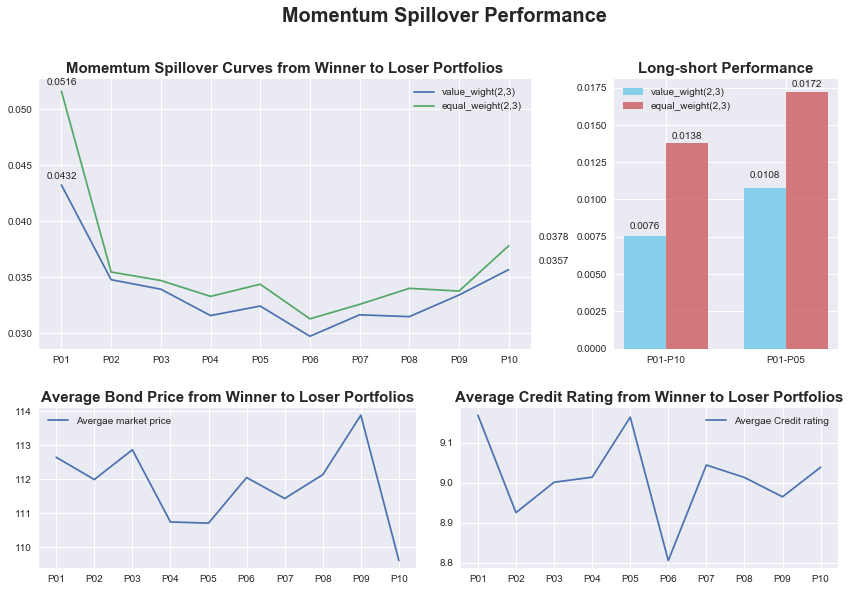

In [22]:
tm_performance_plot(perf)